This file is the post-processing script for GPT-4o generated content.

In [10]:
import json
import os
import pprint 
import re
pp = pprint.PrettyPrinter(indent=4)

# dataset_name = 'meme_retrieval_data'
dataset_name = 'figmemes'
# dataset_name = 'memecap'

# file_suffix = "_1-1537_figmemes_multi_labels"
file_suffix = "_1-11_manually_crafted"

img_prompt_respond_file = ''
if dataset_name == 'meme_retrieval_data':
    img_prompt_respond_file = f'../data/meme_retrieval_data/img_prompt_respond{file_suffix}.json' # img_prompt_respond_1-33283.json
elif dataset_name == 'figmemes':
    img_prompt_respond_file = f'../data/figmemes/img_prompt_respond{file_suffix}.json'
elif  dataset_name == 'memecap':
    img_prompt_respond_file = f'../data/memecap/img_prompt_respond{file_suffix}.json'

meme_configs = []
with open(img_prompt_respond_file, 'r', encoding='utf-8') as json_file:
    meme_configs = json.load(json_file)
len(meme_configs)


11

In [11]:
if dataset_name == 'meme_retrieval_data' or dataset_name == 'memecap':
    literary_device = set("sarcasm, allegory, alliteration, allusion, amplification, anagram, analogy, anthropomorphism, antithesis, chiasmus, circumlocution, euphemism, hyperbole, imagery, metaphor, onomatopoeia, oxymoron, paradox, personification, portmanteau, pun, satire, simile, symbolism, none".split(', '))
elif dataset_name == 'figmemes':
    literary_device = set("allusion, exaggeration, irony, anthrop, metaphor, contrast".split(', '))

emotion_word = set("fear, anger, joy, sadness, surprise, disgust, guilt, contempt, shame, embarrassment, envy, jealousy, love, hate, interest, none".split(', '))
literary_device, emotion_word, len(literary_device), len(emotion_word)

({'allusion', 'anthrop', 'contrast', 'exaggeration', 'irony', 'metaphor'},
 {'anger',
  'contempt',
  'disgust',
  'embarrassment',
  'envy',
  'fear',
  'guilt',
  'hate',
  'interest',
  'jealousy',
  'joy',
  'love',
  'none',
  'sadness',
  'shame',
  'surprise'},
 6,
 16)

# Extract responses into JSON objects 

In [12]:
import re
import json
correction_map = {'anthropomorphism':'anthrop', 'dehumanizing metaphor': 'metaphor'}

counter = 0
meme_annotations = []
invalid_labels = []
number_of_invalid_labels = 0
for i, meme in enumerate(meme_configs):
    new_meme_conf = {}
    new_meme_conf["image_dir"] = meme["image_dir"]
    new_meme_conf["prompt"] = meme["prompt"]
    x = re.sub("```.*\n", "", meme['respond'])
    x = re.sub("```", "", x)
    x = x.strip()
    # print(x)
    try:
        y = json.loads(x)
        if "literary device" in y.keys():
            y["literary device"] = [device.lower() for device in y["literary device"] if device.lower() != 'none']
            # y["literary device"].remove('none')
            valid = True
            for idx in range(len(y['literary device'])):
                device = y['literary device'][idx]
                if device not in literary_device:
                    if device in correction_map.keys():
                        y['literary device'][idx] = correction_map[device]
                        # print('Correcttion: ', device, correction_map[device])
                    else:
                        valid = False   
                        print(y['literary device'])
                        invalid_labels.append(device)
            if valid:
                counter += 1
            else:
                number_of_invalid_labels += 1
        
        new_meme_conf.update(y) # Merge two dictionaries
        meme_annotations.append(new_meme_conf)
    except:
        print("An error has occored when parsing the string")
        pass 
    
'''
{
  "detected text": "My Brother's Husband Is the Hottest Family-Friendly Manga Ever Made by Chase Burns · Feb 11, 2020 at 1:00 pm KIDS ARE LUCKY. THEY DON'T HAVE TO THINK ABOUT THAT STUFF.",
  "meaning of the meme": "The meme showcases a perceived irony where a manga titled 'My Brother's Husband,' featuring themes that might not traditionally be considered family-friendly, is touted as the 'hottest family-friendly manga.' It draws attention to the juxtaposition between the term 'family-friendly' and the content of the manga which deals with complex social issues such as same-sex relationships. The character's dialog emphasizes the innocence of children who do not have to grapple with the social complexities explored in the manga.",
  "literary device": ["Irony", "Contrast"]
}
'''
print(counter, number_of_invalid_labels, len(meme_annotations))
print(set(invalid_labels))
meme_annotations[0]

11 0 11
set()


{'image_dir': './data/figmemes/images/1458964859691.jpg',
 'prompt': 'Tasks: \n1. Extract the texts on the meme;\n2. Explain the meme from three perspectives: the humor of the meme; how the meme conveys the humor; And, the emotion behind the meme;\n3. Choose suitable literary devices from the given candidates;\n4. Choose suitable emotional words from the given candidates\n\nThe context of the meme: {}\n\nEmotion labels: anger, fear, surprise, sadness, disgust, contempt, happiness, none\n\nLiterary devices: \n**Allusion**: Referencing historical events, figures, symbols, art, literature or pop culture.\n \n**Exaggeration**: Similar to Hyperbole. Use of exaggerated terms for emphasis, including exaggerated visuals (including unrealistic features portraying minorities).\n \n**Irony**: Similar to Sarcasm. Use of words that convey a meaning that is the opposite of its usual meaning/mock someone or something with caustic or bitter use of words.\n  \n**Anthropomorphism**: Similar to Zoomorphi

In [13]:
output_file_name = ''
if dataset_name == 'meme_retrieval_data':
    output_file_name = f'../data/meme_retrieval_data/filtered_meme_configs{file_suffix}.json'
elif dataset_name == 'figmemes':
    output_file_name = f'../data/figmemes/filtered_meme_configs{file_suffix}.json'
elif  dataset_name == 'memecap':
    output_file_name = f'../data/memecap/filtered_meme_configs{file_suffix}.json'

# Save JSON file
print(len(meme_annotations))
with open(output_file_name, "w") as outfile: 
      json.dump(meme_annotations, outfile, indent=4)

11


# Statistics and post-check

In [14]:
def str_length_statistics(dataset):
    # ic_label_length = []
    dt_label_length = []
    mc_label_length = []
    ld_label_length = []
    # ew_label_length = []

    for ite in dataset:
        dt_label_length.append(len(ite['detected text'].split()))
        mc_label_length.append(len(ite['meaning of the meme'].split()))
        ld_label_length.append(len(ite['literary device']))

    print(set(dt_label_length))
    print(set(mc_label_length))
    print(set(ld_label_length)) # Good, only 1

    import pandas as pd
    import matplotlib.pyplot as plt
    # Create a DataFrame from the lists
    data = {
        'detected text': dt_label_length,
        'meaning of the meme': mc_label_length,
        'literary device': ld_label_length,
    }
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

    # Plot a boxplot
    plt.figure(figsize=(10, 6))
    df.boxplot()
    plt.title('The distribution of the lengths of responses')
    plt.ylabel('No. of words')
    plt.show()


In [15]:
# print(len(meme_annotations))
# str_length_statistics(meme_annotations)

# Label distribution

In [16]:
from collections import defaultdict

literary_device_label_dict = defaultdict(lambda: 0)
# emotion_label_dict= defaultdict(lambda: 0)

for idx, meme_conf in enumerate(meme_annotations):
    if 'literary device' in meme_conf.keys(): 
        for device in meme_conf['literary device']:
            literary_device_label_dict[device] += 1
pp.pprint(literary_device_label_dict)

defaultdict(<function <lambda> at 0x7fe2b3c6fd00>,
            {   'allusion': 4,
                'anthrop': 2,
                'contrast': 8,
                'exaggeration': 5,
                'irony': 2})


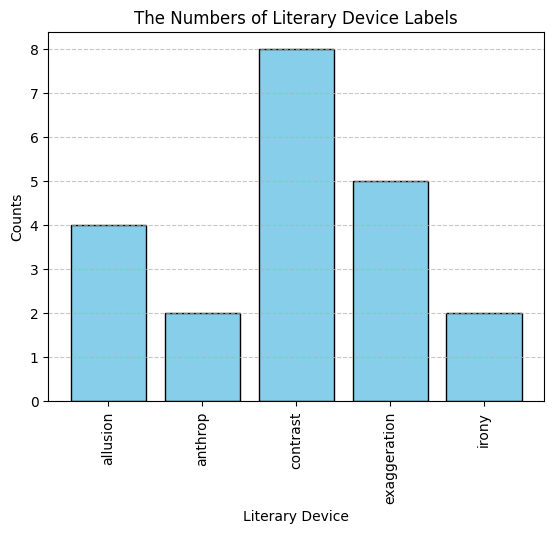

In [17]:
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary
my_keys = list(literary_device_label_dict.keys())
my_keys.sort()

keys = my_keys
values = [literary_device_label_dict[i] for i in my_keys]

# Plot a bar chart
# plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)

plt.title('The Numbers of Literary Device Labels')
plt.xlabel('Literary Device')
plt.ylabel('Counts')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
